In [1]:
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import gzip
import pickle
import os
import torch
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from torch.utils.data import TensorDataset
import pickle
import time
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd

In [37]:
learning_rate = 0.001
batch_size = 64
num_epochs = 25
dropout_rate1 = 0.25
dropout_rate2 = 0.5
num_classes = 10
input_shape = (3, 32, 32)
# train_fraction = 1.0
test_fraction  = 0.15
seed = 13

In [3]:
np.random.seed(seed)
torch.manual_seed(seed)

## Functions

In [4]:
def im2col(x, KH, KW, padding):
    B, C, H, W = x.shape
    H_out = H + 2 * padding - KH + 1
    W_out = W + 2 * padding - KW + 1

    x_padded = np.pad(x, ((0, 0), (0, 0), (padding, padding), (padding, padding)))
    cols = np.zeros((B, C * KH * KW, H_out * W_out))

    for i in range(H_out):
        for j in range(W_out):
            patch = x_padded[:, :, i:i+KH, j:j+KW]
            cols[:, :, i * W_out + j] = patch.reshape(B, -1)

    return cols, H_out, W_out

In [5]:
def col2im(dcols, x_shape, KH, KW, padding):
    B, C, H, W = x_shape
    H_out = H + 2 * padding - KH + 1
    W_out = W + 2 * padding - KW + 1

    dx_padded = np.zeros((B, C, H + 2 * padding, W + 2 * padding))

    for i in range(H_out):
        for j in range(W_out):
            patch = dcols[:, :, i * W_out + j].reshape(B, C, KH, KW)
            dx_padded[:, :, i:i+KH, j:j+KW] += patch

    if padding > 0:
        return dx_padded[:, :, padding:-padding, padding:-padding]
    return dx_padded

In [6]:
def pad2d(x, padding):
    return np.pad(x, ((0, 0), (0, 0), (padding, padding), (padding, padding)))

In [7]:
class Conv2D:
    def __init__(self, in_channels, out_channels, kernel_size, padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.padding = padding
        self.weight = np.random.randn(out_channels, in_channels, *self.kernel_size) * 0.01
        self.bias = np.zeros((out_channels, 1))
        self.d_weight = np.zeros_like(self.weight)
        self.d_bias = np.zeros_like(self.bias)

    def forward(self, x):
        self.x = x
        KH, KW = self.kernel_size
        B = x.shape[0]
        self.cols, self.H_out, self.W_out = im2col(x, KH, KW, self.padding)
        W_col = self.weight.reshape(self.out_channels, -1)
        out = W_col @ self.cols + self.bias
        out = out.reshape(B, self.out_channels, self.H_out, self.W_out)
        return out

    def backward(self, d_out):
        B = d_out.shape[0]
        d_out_flat = d_out.reshape(B, self.out_channels, -1)

        self.d_weight = np.zeros_like(self.weight)
        self.d_bias = np.zeros_like(self.bias)
        dW_col = np.zeros((self.out_channels, self.in_channels * self.kernel_size[0] * self.kernel_size[1]))

        for b in range(B):
            dW_col += d_out_flat[b] @ self.cols[b].T
            self.d_bias += np.sum(d_out_flat[b], axis=1, keepdims=True)

        self.d_weight = dW_col.reshape(self.weight.shape) / B
        self.d_bias /= B

        W_col = self.weight.reshape(self.out_channels, -1)
        dcols = np.zeros_like(self.cols)
        for b in range(B):
            dcols[b] = W_col.T @ d_out_flat[b]

        dx = col2im(dcols, self.x.shape, *self.kernel_size, self.padding)
        return dx

In [8]:
class BatchNorm:
    def __init__(self, channels, eps=1e-5, momentum=0.9):
        self.eps = eps
        self.momentum = momentum
        self.gamma = np.ones((1, channels, 1, 1))
        self.beta = np.zeros((1, channels, 1, 1))
        self.running_mean = np.zeros((1, channels, 1, 1))
        self.running_var = np.ones((1, channels, 1, 1))
        self.d_gamma = np.zeros_like(self.gamma)
        self.d_beta = np.zeros_like(self.beta)

    def forward(self, x, train=True):
        self.x = x
        if train:
            self.mean = x.mean(axis=(0, 2, 3), keepdims=True)
            self.var = x.var(axis=(0, 2, 3), keepdims=True)
            self.std = np.sqrt(self.var + self.eps)
            self.x_hat = (x - self.mean) / self.std
            self.out = self.gamma * self.x_hat + self.beta
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.var
        else:
            x_hat = (x - self.running_mean) / np.sqrt(self.running_var + self.eps)
            self.out = self.gamma * x_hat + self.beta
        return self.out

    def backward(self, d_out):
        N, C, H, W = d_out.shape
        dx_hat = d_out * self.gamma
        d_var = np.sum(dx_hat * (self.x - self.mean) * -0.5 * (self.var + self.eps)**(-1.5), axis=(0, 2, 3), keepdims=True)
        d_mean = np.sum(dx_hat * -1 / self.std, axis=(0, 2, 3), keepdims=True) + \
                 d_var * np.sum(-2 * (self.x - self.mean), axis=(0, 2, 3), keepdims=True) / (N*H*W)
        dx = dx_hat / self.std + d_var * 2 * (self.x - self.mean) / (N*H*W) + d_mean / (N*H*W)
        self.d_gamma = np.sum(d_out * self.x_hat, axis=(0, 2, 3), keepdims=True)
        self.d_beta = np.sum(d_out, axis=(0, 2, 3), keepdims=True)
        return dx

In [9]:
class ReLU:
    def forward(self, x):
        self.mask = x > 0
        return x * self.mask

    def backward(self, d_out):
        return d_out * self.mask

In [10]:
class MaxPool2D:
    def __init__(self, size):
        self.size = size

    def forward(self, x):
        self.x = x
        B, C, H, W = x.shape
        self.H_out, self.W_out = H // self.size, W // self.size
        out = np.zeros((B, C, self.H_out, self.W_out))
        self.max_indices = np.zeros_like(x, dtype=bool)
        for b in range(B):
            for c in range(C):
                for i in range(self.H_out):
                    for j in range(self.W_out):
                        region = x[b, c, i*self.size:(i+1)*self.size, j*self.size:(j+1)*self.size]
                        max_val = np.max(region)
                        out[b, c, i, j] = max_val
                        self.max_indices[b, c, i*self.size:(i+1)*self.size, j*self.size:(j+1)*self.size] = (region == max_val)
        return out

    def backward(self, d_out):
        dx = np.zeros_like(self.x)
        for b in range(dx.shape[0]):
            for c in range(dx.shape[1]):
                for i in range(self.H_out):
                    for j in range(self.W_out):
                        region = self.max_indices[b, c, i*self.size:(i+1)*self.size, j*self.size:(j+1)*self.size]
                        dx[b, c, i*self.size:(i+1)*self.size, j*self.size:(j+1)*self.size] += d_out[b, c, i, j] * region
        return dx

In [11]:
class Dropout:
    def __init__(self, rate):
        self.rate = rate

    def forward(self, x):
        self.mask = (np.random.rand(*x.shape) > self.rate).astype(np.float32)
        return x * self.mask / (1.0 - self.rate)

    def backward(self, d_out):
        return d_out * self.mask / (1.0 - self.rate)

In [12]:
class Flatten:
    def forward(self, x):
        self.orig_shape = x.shape
        return x.reshape(x.shape[0], -1)

    def backward(self, d_out):
        return d_out.reshape(self.orig_shape)

In [13]:
class Linear:
    def __init__(self, in_dim, out_dim):
        self.W = np.random.randn(in_dim, out_dim) * 0.01
        self.b = np.zeros((1, out_dim))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

    def forward(self, x):
        self.x = x
        return x @ self.W + self.b

    def backward(self, d_out):
        d_x = d_out @ self.W.T
        self.dW = self.x.T @ d_out
        self.db = np.sum(d_out, axis=0, keepdims=True)
        return d_x

In [14]:
class SoftmaxCrossEntropy:
    def forward(self, logits, labels):
        self.labels = labels
        exps = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        self.probs = exps / np.sum(exps, axis=1, keepdims=True)
        loss = -np.sum(np.log(self.probs[np.arange(len(labels)), labels])) / len(labels)
        return loss

    def backward(self):
        dx = self.probs.copy()
        dx[np.arange(len(self.labels)), self.labels] -= 1
        return dx / len(self.labels)

In [15]:
class CNNModel:
    def __init__(self):
        C, H, W = input_shape
        self.conv1 = Conv2D(C, 32, kernel_size=3, padding=1)
        self.bn1 = BatchNorm(32)
        self.relu1 = ReLU()

        self.pool1 = MaxPool2D(2)

        self.conv2 = Conv2D(32, 64, kernel_size=3, padding=1)
        self.bn2 = BatchNorm(64)
        self.relu2 = ReLU()

        self.pool2 = MaxPool2D(2)

        self.conv3 = Conv2D(64, 128, kernel_size=3, padding=1)
        self.bn3 = BatchNorm(128)
        self.relu3 = ReLU()

        self.pool3 = MaxPool2D(2)

        self.dropout1 = Dropout(dropout_rate1)
        self.flatten = Flatten()
        self.fc1 = Linear(128 * 4 * 4, 128)
        self.relu_fc = ReLU()
        self.dropout2 = Dropout(dropout_rate2)
        self.fc2 = Linear(128, num_classes)
        self.criterion = SoftmaxCrossEntropy()

    def forward(self, x, y):
        out = self.conv1.forward(x)
        out = self.bn1.forward(out)
        out = self.relu1.forward(out)
        out = self.pool1.forward(out)

        out = self.conv2.forward(out)
        out = self.bn2.forward(out)
        out = self.relu2.forward(out)
        out = self.pool2.forward(out)

        out = self.conv3.forward(out)
        out = self.bn3.forward(out)
        out = self.relu3.forward(out)
        out = self.pool3.forward(out)

        out = self.dropout1.forward(out)
        out = self.flatten.forward(out)
        out = self.fc1.forward(out)
        out = self.relu_fc.forward(out)
        out = self.dropout2.forward(out)
        logits = self.fc2.forward(out)
        loss = self.criterion.forward(logits, y)
        return logits, loss

    def backward(self):
        d_out = self.criterion.backward()
        d_out = self.fc2.backward(d_out)
        d_out = self.dropout2.backward(d_out)
        d_out = self.relu_fc.backward(d_out)
        d_out = self.fc1.backward(d_out)
        d_out = self.flatten.backward(d_out)
        d_out = self.dropout1.backward(d_out)
        d_out = self.pool3.backward(d_out)
        d_out = self.relu3.backward(d_out)
        d_out = self.bn3.backward(d_out)
        d_out = self.conv3.backward(d_out)
        d_out = self.pool2.backward(d_out)
        d_out = self.relu2.backward(d_out)
        d_out = self.bn2.backward(d_out)
        d_out = self.conv2.backward(d_out)
        d_out = self.pool1.backward(d_out)
        d_out = self.relu1.backward(d_out)
        d_out = self.bn1.backward(d_out)
        d_out = self.conv1.backward(d_out)

    def get_params(self):
        return [
            (self.conv1.weight, self.conv1.d_weight),
            (self.conv1.bias, self.conv1.d_bias),
            (self.conv2.weight, self.conv2.d_weight),
            (self.conv2.bias, self.conv2.d_bias),
            (self.conv3.weight, self.conv3.d_weight),
            (self.conv3.bias, self.conv3.d_bias),
            (self.bn1.gamma, self.bn1.d_gamma),
            (self.bn1.beta, self.bn1.d_beta),
            (self.bn2.gamma, self.bn2.d_gamma),
            (self.bn2.beta, self.bn2.d_beta),
            (self.bn3.gamma, self.bn3.d_gamma),
            (self.bn3.beta, self.bn3.d_beta),
            (self.fc1.W, self.fc1.dW),
            (self.fc1.b, self.fc1.db),
            (self.fc2.W, self.fc2.dW),
            (self.fc2.b, self.fc2.db),
        ]

In [16]:
class AdamTorchOptimizer:
    def __init__(self, model):
        self.params = model.get_params()
        self.optim_params = []
        for w, _ in self.params:
            w_tensor = torch.tensor(w, requires_grad=True, dtype=torch.float32)
            self.optim_params.append(w_tensor)
        self.optimizer = torch.optim.Adam(self.optim_params, lr=learning_rate)

    def step(self, model):
        with torch.no_grad():
            for i, (w, grad) in enumerate(model.get_params()):
                self.optim_params[i].grad = torch.tensor(grad, dtype=torch.float32)
            self.optimizer.step()
            for i, (w, _) in enumerate(model.get_params()):
                w[...] = self.optim_params[i].detach().numpy()

In [17]:
def get_balanced_data(dataset, train_size=0.8):
    targets = np.array(dataset.targets) if isinstance(dataset.targets, list) else dataset.targets.numpy()
    class_counts = Counter(targets)
    min_class_count = min(class_counts.values())
    indices_per_class = {i: [] for i in range(10)}
    for idx, target in enumerate(targets):
        if len(indices_per_class[target]) < min_class_count:
            indices_per_class[target].append(idx)
    all_indices = []
    for cls in indices_per_class:
        all_indices.extend(indices_per_class[cls])
    np.random.shuffle(all_indices)
    train_count = int(len(all_indices) * train_size)
    train_indices = all_indices[:train_count]
    test_indices = all_indices[train_count:]
    return Subset(dataset, train_indices), Subset(dataset, test_indices)

In [18]:
def class_distribution(subset):
    loader = DataLoader(subset, batch_size=len(subset), shuffle=False)
    _, labels = next(iter(loader))
    counter = Counter(labels.numpy())
    return dict(counter), sum(counter.values())

In [19]:
def extract_numpy_from_subset(subset):
    loader = DataLoader(subset, batch_size=len(subset), shuffle=False)
    images, labels = next(iter(loader))
    return images.numpy(), labels.numpy()

In [20]:
def reduce_balanced(X, y, fraction):
    assert 0 < fraction <= 1.0
    selected_idx = []
    y = np.array(y)
    unique_classes = np.unique(y)
    for cls in unique_classes:
        cls_idx = np.where(y == cls)[0]
        np.random.shuffle(cls_idx)
        keep = int(len(cls_idx) * fraction)
        selected_idx.extend(cls_idx[:keep])
    selected_idx = np.array(selected_idx)
    return X[selected_idx], y[selected_idx]

## Main

In [21]:
transform = transforms.ToTensor()
cifar_full = CIFAR10(root="./data", train=True, download=True, transform=transform)
cifar_train, cifar_test = get_balanced_data(cifar_full)

Files already downloaded and verified


In [22]:
train_dist, train_total = class_distribution(cifar_train)
test_dist, test_total = class_distribution(cifar_test)

In [23]:
print("Train set (Before Reduction):", train_total, sorted(list(train_dist.values())))
print("Test set (Before Reduction):", test_total, sorted(list(test_dist.values())))

Train set (Before Reduction): 40000 [3950, 3954, 3968, 3985, 3999, 4010, 4011, 4031, 4042, 4050]
Test set (Before Reduction): 10000 [950, 958, 969, 989, 990, 1001, 1015, 1032, 1046, 1050]


In [24]:
X_train, y_train = extract_numpy_from_subset(cifar_train)
X_test, y_test = extract_numpy_from_subset(cifar_test)

In [25]:
# X_train, y_train = reduce_balanced(X_train, y_train, train_fraction)
X_test, y_test = reduce_balanced(X_test, y_test, test_fraction)

In [26]:
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)

X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

train_com = TensorDataset(X_train_tensor, y_train_tensor)
test_com = TensorDataset(X_test_tensor, y_test_tensor)

In [27]:
train_dist, train_total = class_distribution(train_com)
test_dist, test_total = class_distribution(test_com)

In [28]:
print("Train set (After Reduction):", train_total, sorted(list(train_dist.values()))) 
print("Test set (After Reduction):", test_total, sorted(list(test_dist.values()))) 

Train set (After Reduction): 40000 [3950, 3954, 3968, 3985, 3999, 4010, 4011, 4031, 4042, 4050]
Test set (After Reduction): 1495 [142, 143, 145, 148, 148, 150, 152, 154, 156, 157]


In [29]:
train_losses, train_accs = [], []
test_losses, test_accs = [], []
best_acc = 0
best_model = None

In [30]:
model = CNNModel()
optimizer = AdamTorchOptimizer(model)

In [31]:
for epoch in range(num_epochs):
    perm = np.random.permutation(len(X_train))
    X_train_epoch = X_train[perm]
    y_train_epoch = y_train[perm]
    epoch_train_loss = 0
    train_preds = []
    train_targets = []

    for i in range(0, len(X_train_epoch), batch_size):
        xb = X_train_epoch[i:i+batch_size]
        yb = y_train_epoch[i:i+batch_size]
        logits, loss = model.forward(xb, yb)
        model.backward()
        optimizer.step(model)
        epoch_train_loss += loss
        train_preds.extend(np.argmax(logits, axis=1))
        train_targets.extend(yb)

    avg_train_loss = epoch_train_loss / (len(X_train_epoch) // batch_size)
    train_acc = accuracy_score(train_targets, train_preds)
    train_losses.append(avg_train_loss)
    train_accs.append(train_acc)

    epoch_test_loss = 0
    test_preds = []
    test_targets = []
    for i in range(0, len(X_test), batch_size):
        xb = X_test[i:i+batch_size]
        yb = y_test[i:i+batch_size]
        logits, loss = model.forward(xb, yb)
        epoch_test_loss += loss
        preds = np.argmax(logits, axis=1)
        test_preds.extend(preds)
        test_targets.extend(yb)

    avg_test_loss = epoch_test_loss / (len(X_test) // batch_size)
    test_acc = accuracy_score(test_targets, test_preds)
    test_losses.append(avg_test_loss)
    test_accs.append(test_acc)

    print(f"[Epoch {epoch+1}/{num_epochs}] Train-Loss: {avg_train_loss:.4f} Train-Acc: {train_acc:.4f}\nTest-Loss: {avg_test_loss:.4f} Test-Acc: {test_acc:.4f}\n")

    if test_acc > best_acc:
        best_acc = test_acc
        best_model = pickle.loads(pickle.dumps(model))
        with open("best_model_cifar10 (Full).pkl", "wb") as f:
            pickle.dump(model, f)

[Epoch 1/25] Train-Loss: 1.5148 Train-Acc: 0.4383
Test-Loss: 2.1481 Test-Acc: 0.3472

[Epoch 2/25] Train-Loss: 1.1869 Train-Acc: 0.5743
Test-Loss: 2.0120 Test-Acc: 0.3893

[Epoch 3/25] Train-Loss: 1.0538 Train-Acc: 0.6266
Test-Loss: 2.0714 Test-Acc: 0.4007

[Epoch 4/25] Train-Loss: 0.9680 Train-Acc: 0.6621
Test-Loss: 1.9779 Test-Acc: 0.4274

[Epoch 5/25] Train-Loss: 0.9101 Train-Acc: 0.6814
Test-Loss: 1.9989 Test-Acc: 0.4301

[Epoch 6/25] Train-Loss: 0.8509 Train-Acc: 0.7029
Test-Loss: 1.8954 Test-Acc: 0.4448

[Epoch 7/25] Train-Loss: 0.8065 Train-Acc: 0.7183
Test-Loss: 2.0226 Test-Acc: 0.4528

[Epoch 8/25] Train-Loss: 0.7571 Train-Acc: 0.7357
Test-Loss: 1.9968 Test-Acc: 0.4635

[Epoch 9/25] Train-Loss: 0.7265 Train-Acc: 0.7469
Test-Loss: 1.9987 Test-Acc: 0.4689

[Epoch 10/25] Train-Loss: 0.6878 Train-Acc: 0.7600
Test-Loss: 1.8942 Test-Acc: 0.4829

[Epoch 11/25] Train-Loss: 0.6594 Train-Acc: 0.7704
Test-Loss: 1.9525 Test-Acc: 0.4729

[Epoch 12/25] Train-Loss: 0.6330 Train-Acc: 0.7796
T

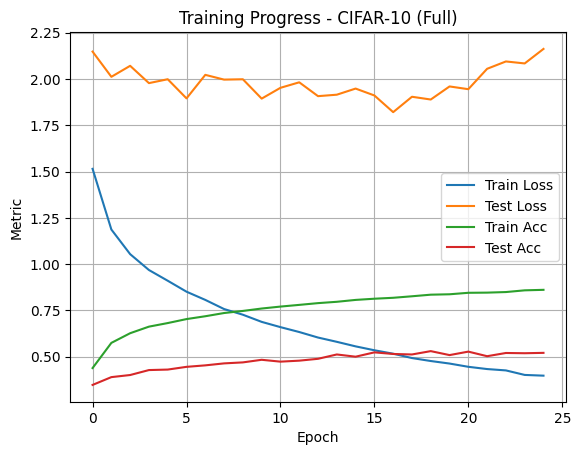

In [32]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.plot(train_accs, label="Train Acc")
plt.plot(test_accs, label="Test Acc")
plt.title("Training Progress - CIFAR-10 (Full)")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.grid()
plt.show()

In [33]:
final_preds = []

In [34]:
for i in range(0, len(X_test), batch_size):
    xb = X_test[i:i+batch_size]
    logits, _ = best_model.forward(xb, y_test[i:i+batch_size])
    preds = np.argmax(logits, axis=1)
    final_preds.extend(preds)

Confusion Matrix:


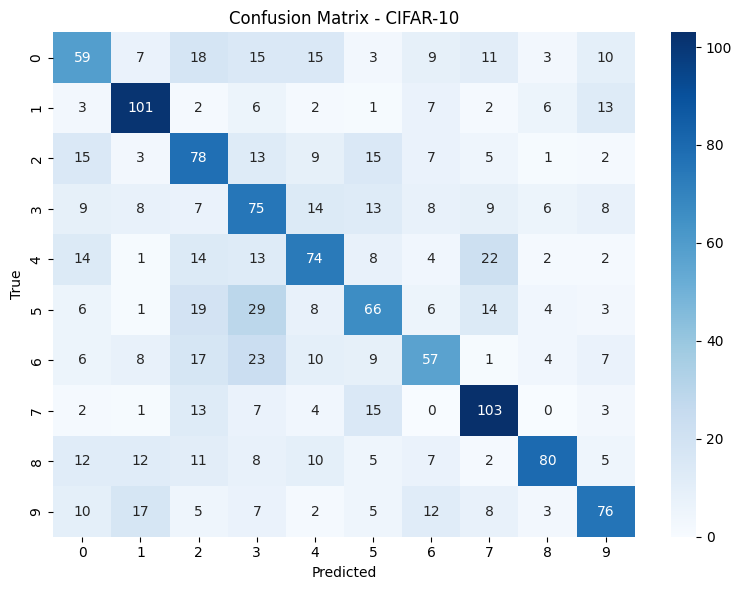

In [35]:
print("Confusion Matrix:")
cm = confusion_matrix(y_test[:len(final_preds)], final_preds)
labels = [str(i) for i in range(10)]
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CIFAR-10")
plt.tight_layout()
plt.show()

In [36]:
print("Accuracy:", accuracy_score(y_test[:len(final_preds)], final_preds))
print("F1 Score:", f1_score(y_test[:len(final_preds)], final_preds, average='macro'))

Accuracy: 0.51438127090301
F1 Score: 0.5154054391898306
